# Hate Speech Detection with BERT, Adversarial Training (FGM), and Explainability

This notebook implements a hate speech/offensive language detection model based on the project proposal. It fine-tunes a pre-trained BERT model using PyTorch, incorporating:

1.  **Data Loading & Preprocessing:** Handles TSV/CSV files, basic text cleaning, and preparation for BERT.
2.  **BERT Fine-tuning:** Uses Hugging Face Transformers for model loading and training.
3.  **Adversarial Training:** Implements the Fast Gradient Method (FGM) on embeddings as an optional technique to improve robustness.
4.  **Evaluation:** Calculates standard classification metrics (Accuracy, F1, Precision, Recall) and generates reports/visualizations.
5.  **Explainability:** Provides basic attention visualization to understand model focus.
6.  **Configuration:** Key parameters are set in a dedicated cell for easy experimentation.
7.  **Early Stopping:** Optional mechanism to prevent overfitting.
8.  **Artifact Saving:** Saves the trained model, tokenizer, results, and plots.

## 1. Setup and Imports

Import necessary libraries and set up basic configurations.

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import os
import json
import time
import random
from copy import deepcopy
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm
import re

## 2. Configuration

Set hyperparameters, file paths, model name, and feature flags here. Adjust these values for your specific dataset and experiments.

In [93]:
'''print("Working dir:", os.getcwd())
print("Root contents:", os.listdir(os.getcwd()))
print("Data folder contents:", os.listdir(os.path.join(os.getcwd(), 'HASOCData')))
print("HASOCData contents (if any):", os.listdir(os.path.join(os.getcwd(), 'HASOCData')))'''


'print("Working dir:", os.getcwd())\nprint("Root contents:", os.listdir(os.getcwd()))\nprint("Data folder contents:", os.listdir(os.path.join(os.getcwd(), \'HASOCData\')))\nprint("HASOCData contents (if any):", os.listdir(os.path.join(os.getcwd(), \'HASOCData\')))'

In [53]:
# --- Core Configuration ---
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128  # Max sequence length for BERT tokenizer
BATCH_SIZE = 16 # Reduce if facing GPU memory issues
EPOCHS = 10     # Number of training epochs
LEARNING_RATE = 1e-5 # Standard learning rate for BERT fine-tuning
SEED = 42      # Random seed for reproducibility
OUTPUT_DIR = 'model_output' # Directory to save model, results, plots
VAL_SPLIT_SIZE = 0.1 # Proportion of training data to use for validation

# --- Feature Flags ---
USE_FGM = True # Set to True to enable Fast Gradient Method adversarial training
ADVERSARIAL_EPS = 0.5 # Epsilon for FGM perturbation (if USE_FGM is True)
USE_EARLY_STOPPING = True # Set to True to enable early stopping
PATIENCE = 3 # Number of epochs to wait for improvement before stopping (if USE_EARLY_STOPPING is True)

# --- Dataset Configuration ---
BASE_DIR = os.getcwd()
print("Base dir:", BASE_DIR)
# Choose one dataset type to configure
DATASET_TYPE = 'HASOC' # Options: 'OLID', 'HASOC', 'OffenseEval'
# For OLID & OffenseEval use 'a','b','c'; for HASOC use '1','2','3'
SUBTASK = '1'        # e.g. HASOC subtask 1 (task_1), 2 (task_2), or 3 (task_3)


# File paths
if DATASET_TYPE == 'OLID':
    DATA_DIR   = os.path.join(BASE_DIR, 'OlidPreprcessed')
    TRAIN_FILE = os.path.join(DATA_DIR, 'OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt')
    print(f"Train file: {TRAIN_FILE}")
    
    # pick the right test file for a, b or c
    TEST_FILE  = os.path.join(
        DATA_DIR,
        f'OLID_TEST_{SUBTASK.upper()}_ATUSER_URL_EmojiRemoved_Pedro.txt'
    )
    print(f"Test file: {TEST_FILE}")
    TEST_LABELS_FILE = None
    TEXT_COLUMN = 'tweet'
    
    # label column + map per subtask
    LABEL_COLUMN = f'subtask_{SUBTASK.lower()}'
    if SUBTASK == 'a':
        LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b':
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else:  # c
        LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}
    NUM_LABELS = len(LABEL_MAP)


elif DATASET_TYPE == 'HASOC':
    # include the Project_folder in path
    DATA_DIR    = os.path.join(BASE_DIR, 'HASOCData')
    TRAIN_FILE  = os.path.join(DATA_DIR, 'english_dataset.tsv')
    print(f"Train file: {TRAIN_FILE}")
    TEST_FILE   = os.path.join(DATA_DIR, 'hasoc2019_en_test-2919.tsv')
    TEST_LABELS_FILE = None

    TEXT_COLUMN  = 'tweet'
    LABEL_COLUMN = f'task_{SUBTASK}'
    if SUBTASK == '1':
        LABEL_MAP = {'NOT': 0, 'HOF': 1}
    elif SUBTASK == '2':
        LABEL_MAP = {'HATE': 0, 'OFFN': 1, 'PRFN': 2}
    else:  # '3'
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    NUM_LABELS = len(LABEL_MAP)


elif DATASET_TYPE == 'OffenseEval':
    DATA_DIR = os.path.join(BASE_DIR, 'OffenseEval')
    # Train: all nine parts for subtask A, or distant files for B/C
    if SUBTASK == 'a':
        part_paths = [os.path.join(DATA_DIR, f'task_a_part{i}.xlsx') for i in range(1, 10)]
        # load & concat all parts:
        TRAIN_FILE = None
        train_dfs = [pd.read_excel(p) for p in part_paths if os.path.exists(p)]
        df_train_all = pd.concat(train_dfs, ignore_index=True)
    elif SUBTASK == 'b':
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_b_distant.xlsx')
    else:  # 'c'
        TRAIN_FILE = os.path.join(DATA_DIR, 'task_c_distant_ann.xlsx')

    TEST_DIR = DATA_DIR
    TEST_FILE = os.path.join(TEST_DIR, f'test_{SUBTASK}.tsv')  # or whatever your naming is
    TEST_LABELS_FILE = None

    TEXT_COLUMN  = 'tweet'
    LABEL_COLUMN = f'subtask_{SUBTASK}'
    if SUBTASK == 'a':
        LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b':
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else:  # 'c'
        LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}
    NUM_LABELS = len(LABEL_MAP)

else:
    raise ValueError("Invalid DATASET_TYPE. Choose from 'OLID', 'HASOC', 'OffenseEval'.")

# --- Create output directory ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Save Configuration to JSON (for record keeping) ---
config_dict = {
    'MODEL_NAME': MODEL_NAME,
    'MAX_LEN': MAX_LEN,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'SEED': SEED,
    'OUTPUT_DIR': OUTPUT_DIR,
    'DATASET_TYPE': DATASET_TYPE,
    'BASE_DIR': BASE_DIR,
    'TRAIN_FILE': locals().get('TRAIN_FILE'),
    'TEST_FILE': locals().get('TEST_FILE'),
    'TEST_LABELS_FILE': TEST_LABELS_FILE,
    'TEXT_COLUMN': TEXT_COLUMN,
    'LABEL_COLUMN': LABEL_COLUMN,
    'LABEL_MAP': LABEL_MAP,
    'NUM_LABELS': NUM_LABELS,
    'VAL_SPLIT_SIZE': VAL_SPLIT_SIZE,
    'USE_FGM': USE_FGM,
    'ADVERSARIAL_EPS': ADVERSARIAL_EPS if USE_FGM else None,
    'USE_EARLY_STOPPING': USE_EARLY_STOPPING,
    'PATIENCE': PATIENCE if USE_EARLY_STOPPING else None
}

config_filename = f"config_{DATASET_TYPE}.json"
config_path     = os.path.join(OUTPUT_DIR, config_filename)
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=4)

print(f"Configuration saved to {config_path}")

Base dir: /
Train file: /HASOCData/english_dataset.tsv
Configuration saved to model_output/config_HASOC.json


## 3. Environment Setup

Set random seeds for reproducibility and select the compute device (GPU if available, otherwise CPU).

In [8]:
def set_seed(seed_value: int):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        # These two lines are for deterministic behavior, can slightly slow down training
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Using CPU')

# Rough Training Time Estimate (for RTX 2080 Ti):
# Depending on dataset size (e.g., ~10k-100k samples) and MAX_LEN,
# expect training time to be roughly:
# - Small dataset (~10k): Few minutes per epoch.
# - Medium dataset (~50k-100k): 15-60 minutes per epoch.
# - Large dataset (>100k): Potentially several hours per epoch.
# FGM adds a small overhead (extra forward/backward pass per step).

Using GPU: NVIDIA GeForce RTX 2080 Ti


## 4. Data Loading and Preprocessing

Load data from files, perform basic cleaning, map labels, and split into train/validation/test sets.

In [9]:
def preprocess_text(text: str) -> str:
    """Basic text cleaning for social media text."""
    if not isinstance(text, str):
        text = str(text)
    text = text.lower() # Lowercase
    # Replace user mentions (keeping a generic token might be useful)
    text = re.sub(r'@\w+', '@USER', text)
    # Optional: Replace URLs
    text = re.sub(r'http\S+|www.\S+', 'HTTPURL', text)
    # Optional: Remove punctuation (Generally NOT recommended for BERT initially)
    # import string
    # text = text.translate(str.maketrans('', '', string.punctuation))
    # Optional: Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Quick sanity‐check
assert preprocess_text("Hello  WORLD!!") == "hello world!!"
assert preprocess_text("@john check this out") == "@USER check this out"
print("Preprocessed text looks good.")


Preprocessed text looks good.


In [10]:
# Cell 3: Robust file loading + tests
def load_data(file_path: str, sep: str = '\t') -> Optional[pd.DataFrame]:
    """Load a TSV or CSV file, falling back if necessary."""
    print(f"Loading {file_path!r} (sep='{sep}')…")
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None

    try:
        df = pd.read_csv(file_path, sep=sep, quoting=3, on_bad_lines='warn')
        print(f"✔️ Loaded with sep='{sep}', shape={df.shape}")
        return df
    except Exception as e:
        print(f"⚠️ Failed with sep='{sep}': {e}")

    if sep == '\t':
        print("→ Retrying with sep=','…")
        try:
            df = pd.read_csv(file_path, on_bad_lines='warn')
            print(f"✔️ Loaded with sep=',', shape={df.shape}")
            return df
        except Exception as e2:
            print(f"❌ Still failed: {e2}")

    return None

In [25]:
# Cell 4: Full pipeline for OLID / HASOC / OffenseEval
def load_and_preprocess_data(
    train_path: str,
    test_path: str,
    text_col: str,
    label_col: str,
    label_map: Dict[str, int],
    test_labels_path: Optional[str] = None,
    val_split: float = 0.1,
    seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    """
    1) Loads train/test from disk
    2) Filters out any rows whose label_col isn't in label_map.keys()
    3) Applies preprocess_text, maps labels → ints, drops NaNs
    4) Stratified train/val split
    5) Returns (train_df, val_df, test_df) where test_df may lack 'label'
    """
    # --- 1. Load DataFrames ---
    df_train = load_data(train_path)
    if df_train is None:
        raise RuntimeError(f"Cannot load train data at {train_path}")
    df_test = load_data(test_path)  # may be None

    # --- 2. Validate required columns in train ---
    missing = {text_col, label_col} - set(df_train.columns)
    if missing:
        raise ValueError(f"Train data missing columns: {missing}")

    # --- 3. Filter/Map train labels ---
    # Keep only rows whose raw label is in label_map (drops e.g. HASOC 'NONE')
    df_train = df_train[df_train[label_col].isin(label_map.keys())].reset_index(drop=True)
    # Map to ints; drop any that still map to NaN
    df_train['label'] = df_train[label_col].map(label_map)
    df_train.dropna(subset=['label'], inplace=True)
    df_train['label'] = df_train['label'].astype(int)

    # --- 4. Clean train text ---
    df_train['clean_text'] = df_train[text_col].apply(preprocess_text)
    before = len(df_train)
    df_train.dropna(subset=['clean_text'], inplace=True)
    df_train = df_train[df_train['clean_text'].str.len() > 0]
    if len(df_train) < before:
        print(f"Dropped {before - len(df_train)} invalid train rows")
    
    # --- 5. Process test set if available ---
    df_test_clean: Optional[pd.DataFrame] = None
    if df_test is not None and text_col in df_test.columns:
        df_test['clean_text'] = df_test[text_col].apply(preprocess_text)

        if label_col in df_test.columns:
            # Filter/mapping analogous to train
            df_test = df_test[df_test[label_col].isin(label_map.keys())].reset_index(drop=True)
            df_test['label'] = df_test[label_col].map(label_map)
            df_test.dropna(subset=['label'], inplace=True)
            df_test['label'] = df_test['label'].astype(int)
            df_test_clean = df_test[['clean_text', 'label']].copy()
        else:
            # unlabeled (OLID test); keep id if present
            cols = ['clean_text']
            if 'id' in df_test.columns:
                cols.insert(0, 'id')
            df_test_clean = df_test[cols].copy()
        
        # final drop of empty text
        before_test = len(df_test_clean)
        df_test_clean.dropna(subset=['clean_text'], inplace=True)
        df_test_clean = df_test_clean[df_test_clean['clean_text'].str.len() > 0]
        if len(df_test_clean) < before_test:
            print(f"Dropped {before_test - len(df_test_clean)} invalid test rows")

    # --- 6. Train/Val split ---
    if df_train['label'].nunique() < 2 or len(df_train) < 2:
        raise RuntimeError("Not enough classes or samples for train/val split")
    try:
        df_tr, df_val = train_test_split(
            df_train[['clean_text','label']],
            test_size=val_split,
            random_state=seed,
            stratify=df_train['label']
        )
    except ValueError:
        print("Stratified split failed, retrying without stratification")
        df_tr, df_val = train_test_split(
            df_train[['clean_text','label']],
            test_size=val_split,
            random_state=seed
        )

    return (
        df_tr.reset_index(drop=True),
        df_val.reset_index(drop=True),
        df_test_clean.reset_index(drop=True) if df_test_clean is not None else None
    )

In [39]:
df_train, df_val, df_test = load_and_preprocess_data(
    train_path       = TRAIN_FILE,
    test_path        = TEST_FILE,
    text_col         = TEXT_COLUMN,
    label_col        = LABEL_COLUMN,
    label_map        = LABEL_MAP,
    test_labels_path = TEST_LABELS_FILE,
    val_split        = VAL_SPLIT_SIZE,
    seed             = SEED
)

print(f"▶️ Train: {len(df_train)} rows; Val: {len(df_val)} rows; "
      f"Test: {len(df_test) if df_test is not None else 'N/A'}")

print("Train label dist:\n", df_train['label'].value_counts(normalize=True))
print("Val   label dist:\n", df_val['label'].value_counts(normalize=True))
if df_test is not None and 'label' in df_test.columns:
    print("Test  label dist:\n", df_test['label'].value_counts(normalize=True))
else:
    print("Test  label dist:\n N/A (test set unlabeled)")

Loading '/HASOCData/english_dataset.tsv' (sep='	')…
✔️ Loaded with sep='	', shape=(5852, 5)
Loading '/HASOCData/hasoc2019_en_test-2919.tsv' (sep='	')…
✔️ Loaded with sep='	', shape=(1153, 5)
▶️ Train: 2034 rows; Val: 227 rows; Test: 288
Train label dist:
 label
1    0.902655
0    0.097345
Name: proportion, dtype: float64
Val   label dist:
 label
1    0.903084
0    0.096916
Name: proportion, dtype: float64
Test  label dist:
 label
1    0.850694
0    0.149306
Name: proportion, dtype: float64


## 5. PyTorch Dataset and DataLoader

Create a custom PyTorch `Dataset` to handle text tokenization on-the-fly and `DataLoader` for batching.

In [40]:
class TextClassificationDataset(Dataset):
    """PyTorch Dataset for text classification tasks."""
    def __init__(self, texts: List[str], labels: List[int], tokenizer: BertTokenizer, max_len: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }
        # only add labels if we have them
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# --- Initialize Tokenizer ---
print(f"Loading tokenizer for model: {MODEL_NAME}")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# --- Create train/val datasets & loaders ---
train_dataset = TextClassificationDataset(
    texts=df_train['clean_text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
val_dataset = TextClassificationDataset(
    texts=df_val['clean_text'].tolist(),
    labels=df_val['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# persistent_workers = True if torch.__version__ >= '1.7' and torch.cuda.is_available() else False
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0,)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0)

print(f"▶️ Train loader: {len(train_dataset)} samples")
print(f"▶️ Val   loader: {len(val_dataset)} samples")

# --- Create test loader only if 'label' exists ---
test_loader = None
if df_test is not None and 'label' in df_test.columns and len(df_test) > 0:
    test_dataset = TextClassificationDataset(
        texts=df_test['clean_text'].tolist(),
        labels=df_test['label'].tolist(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=0)
    print(f"▶️ Test  loader: {len(test_dataset)} samples")
else:
    print("ℹ️ No labeled test set found → skipping test DataLoader")

Loading tokenizer for model: bert-base-uncased
▶️ Train loader: 2034 samples
▶️ Val   loader: 227 samples
▶️ Test  loader: 288 samples


## 6. Model Loading

Load the pre-trained BERT model for sequence classification.

In [41]:
print(f"Loading pre-trained model: {MODEL_NAME}")
try:
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS, # Binary classification
        # output_attentions=True, # Set to True if you want attentions *during training*
        # output_hidden_states=True, # Set to True if you want hidden states *during training*
    )
except Exception as e:
    raise SystemExit(f"Failed to load model {MODEL_NAME}: {e}. Check model name and internet connection.")

# Move model to the appropriate device
model.to(device)
print("Model loaded and moved to device.")

Loading pre-trained model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device.


## 7. Adversarial Training (FGM)

Define the Fast Gradient Method (FGM) class to perturb word embeddings during training. This is applied only if `USE_FGM` is `True`.

In [15]:
class FGM:
    """
    Fast Gradient Method (FGM) for adversarial training on word embeddings.
    Applies perturbation to the model's embedding matrix.
    """
    def __init__(self, model: nn.Module, emb_name: str = 'word_embeddings', epsilon: float = 1.0):
        self.model = model
        self.epsilon = epsilon
        self.emb_name = emb_name # Usually 'word_embeddings' in BERT
        self.backup = {}
        self.embedding_layer_param = None

        # Find the parameter corresponding to the embedding layer dynamically
        for name, param in self.model.named_parameters():
            # Check if the parameter's name contains the embedding layer name
            if self.emb_name in name:
                print(f"FGM: Found embedding layer parameter: {name}")
                self.embedding_layer_param = param
                self.embedding_param_name = name
                break

        if self.embedding_layer_param is None:
            print(f"Warning: FGM could not find embedding layer parameter named like '{self.emb_name}'. Adversarial training will be disabled.")

    def attack(self):
        """Calculates and applies the perturbation."""
        # Only attack during training and if the embedding parameter was found
        if self.embedding_layer_param is None or not self.model.training:
            return

        # Get the parameter and its gradient
        param = self.embedding_layer_param
        if param.requires_grad and param.grad is not None:
             self.backup[self.embedding_param_name] = param.data.clone()
             # Calculate the perturbation r_at
             norm = torch.norm(param.grad)
             if norm != 0 and not torch.isnan(norm):
                r_at = self.epsilon * param.grad / norm
                param.data.add_(r_at) # Apply the perturbation
             # else:
                # print(f"Warning: Zero or NaN norm for gradient of {self.embedding_param_name}. Skipping perturbation.")
        # else:
             # print(f"Warning: Gradient for {self.embedding_param_name} is None or requires_grad=False. Skipping FGM attack for this step.")


    def restore(self):
        """Restores the original embedding weights."""
        if self.embedding_layer_param is None:
            return

        # Restore the parameter data from backup
        if self.embedding_param_name in self.backup:
            self.embedding_layer_param.data = self.backup[self.embedding_param_name]
        self.backup = {} # Clear the backup

# Initialize FGM if enabled
fgm = None
if USE_FGM:
    print("Initializing FGM...")
    # For Hugging Face BERT, the embeddings are typically model.bert.embeddings.word_embeddings.weight
    # We need to find the parameter corresponding to this weight tensor.
    # The FGM class now searches for the parameter name containing 'word_embeddings'.
    fgm = FGM(model, emb_name='word_embeddings', epsilon=ADVERSARIAL_EPS)
    if fgm.embedding_layer_param is None:
        print("Disabling FGM as embedding layer parameter was not found.")
        USE_FGM = False # Disable if initialization failed
else:
    print("FGM Adversarial Training is disabled.")

Initializing FGM...
FGM: Found embedding layer parameter: bert.embeddings.word_embeddings.weight


## 8. Training Loop

Define functions for a single training epoch and evaluation, then implement the main training loop.

In [42]:
def train_epoch(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device, scheduler: torch.optim.lr_scheduler._LRScheduler, n_examples: int, use_fgm: bool, fgm_instance: FGM | None):
    """Performs a single training epoch."""
    model.train() # Set model to training mode
    total_loss = 0
    correct_predictions = 0

    # Wrap your DataLoader
    loop = tqdm(
        enumerate(data_loader),
        total=len(data_loader),
        desc=f"Batches trained",
        leave=False
    )

    for batch_num, batch in loop:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # --- Standard Forward & Backward Pass ---
        optimizer.zero_grad() # Zero gradients at the start of the batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)    # labels=None for forward pass
        logits = outputs.logits
        loss = loss_fn(logits, labels)  # Use the loss function with class weights

        total_loss += loss.item()

        # Calculate accuracy for the batch
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item() # Use .item() for scalar

        # Standard backward pass to calculate gradients
        loss.backward()

        # --- FGM Attack (if enabled) ---
        if use_fgm and fgm_instance is not None:
            # Check if FGM was successfully initialized and can attack
            if fgm_instance.embedding_layer_param is not None and fgm_instance.embedding_layer_param.grad is not None:
                fgm_instance.attack() # Perturb embeddings based on current gradients

                # Adversarial forward pass
                outputs_adv_logits = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=None
                ).logits
                loss_adv = loss_fn(outputs_adv_logits, labels) # Use weighted loss function

                # Adversarial backward pass (gradients accumulate)
                loss_adv.backward()

                fgm_instance.restore() # Restore original embeddings
            # else:
                 # print("FGM condition not met (embedding param not found or grad is None).")
        # --- End FGM ---

        # Clip gradients (optional but often helpful)
        # Applies to accumulated gradients if FGM was used
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights and learning rate
        optimizer.step()
        scheduler.step()

        # Update tqdm postfix
        loop.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc":  f"{(preds==labels).float().mean().item():.4f}"
        })

        # Print progress every N batches
        if (batch_num + 1) % 100 == 0:
             # Calculate batch accuracy using only current batch's data
             batch_preds = torch.argmax(outputs.logits, dim=1)
             batch_acc = torch.sum(batch_preds == labels).item() / len(labels)
             print(f'  Batch {batch_num + 1}/{len(data_loader)}, Loss: {loss.item():.4f}, Batch Acc: {batch_acc:.4f}')

    avg_loss = total_loss / len(data_loader)
    # Use correct_predictions accumulated across all batches for total accuracy
    accuracy = correct_predictions / n_examples
    return avg_loss, accuracy


def eval_model(model: nn.Module, data_loader: DataLoader, device: torch.device, n_examples: int, loss_fn: nn.Module = None):
    """Evaluates the model on a given dataset."""
    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []

    # Handle case where data_loader is None (e.g., test data not loaded)
    if data_loader is None or len(data_loader) == 0:
        print("⚠️ Evaluation data loader is empty or None. Skipping.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=None
            )
            loss   = outputs.loss
            logits = outputs.logits

            # accumulate loss
            if loss_fn:
                total_loss += loss_fn(logits, labels).item()
            else:
                total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    # Use sklearn metrics
    accuracy  = accuracy_score(all_labels, all_preds)
    f1         = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision  = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall     = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, f1, precision, recall, all_labels, all_preds

# --- Setup before Training Loop ---

# Compute Class Weights (using df_train assumed to be loaded)
print("Computing class weights...")
classes = np.unique(df_train['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train['label'])
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights computed:", dict(zip(classes, weights)))

# Define the Weighted Loss Function
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
print(f"Using weighted CrossEntropyLoss on device: {device}")

# --- Optimizer and Scheduler ---
# Parameters with requires_grad=False will be ignored automatically by AdamW
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Calculate total training steps
num_training_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * len(train_loader)), # Optional: set a number of warmup steps (e.g., int(0.1 * num_training_steps))
    num_training_steps=num_training_steps
)


# --- Training Loop ---
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_epoch = -1

print(f"Starting training on {DATASET_TYPE} subtask {SUBTASK.upper()}...")
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        loss_fn, # Pass loss_fn even if not explicitly used in train_epoch
        optimizer,
        device,
        scheduler,
        len(train_dataset), # Use dataset length for total samples
        USE_FGM, # Pass the flag
        fgm      # Pass the FGM instance
    )
    print(f'Epoch {epoch + 1} Training   -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    val_loss, val_acc, val_f1, val_precision, val_recall, _, _ = eval_model(
        model,
        val_loader,
        device,
        len(val_dataset), # Use dataset length for total samples
        loss_fn # Pass loss_fn
    )
    print(f'Epoch {epoch + 1} Validation -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        print(f'Validation loss improved ({best_val_loss:.4f} --> {val_loss:.4f}). Saving best model state...')
        best_val_loss = val_loss
        best_epoch = epoch
        # Save the best model state in memory
        best_model_state = deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f'Validation loss did not improve. Counter: {epochs_no_improve}/{PATIENCE}')

    # Activate early stopping if enabled and patience is reached
    if USE_EARLY_STOPPING and epochs_no_improve >= PATIENCE:
        print(f'\nEarly stopping triggered after {epoch + 1} epochs (no improvement for {PATIENCE} epochs).')
        break
    # --- End Early Stopping Check ---

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch duration: {epoch_duration:.2f} seconds")

total_training_time = time.time() - start_time
print(f'\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)')

# --- Load the best model state found during training ---
if best_model_state is not None:
    print(f"\nLoading best model state from epoch {best_epoch + 1} for final evaluation and saving...")
    model.load_state_dict(best_model_state)
else:
    print("\nWarning: No best model state saved (e.g., training stopped too early, or no improvement). Using the final model state.")


Computing class weights...
Class weights computed: {np.int64(0): np.float64(5.136363636363637), np.int64(1): np.float64(0.553921568627451)}
Using weighted CrossEntropyLoss on device: cuda
Starting training on HASOC subtask 3...

--- Epoch 1/10 ---


Batches trained:   0%|          | 0/128 [00:00<?, ?it/s]

  Batch 100/128, Loss: 0.5094, Batch Acc: 0.8750
Epoch 1 Training   -> Loss: 0.6532, Accuracy: 0.7060
Epoch 1 Validation -> Loss: 0.5902, Accuracy: 0.7841, F1: 0.8209, Precision: 0.8857, Recall: 0.7841
Validation loss improved (inf --> 0.5902). Saving best model state...
Epoch duration: 33.19 seconds

--- Epoch 2/10 ---


Batches trained:   0%|          | 0/128 [00:00<?, ?it/s]

  Batch 100/128, Loss: 0.2829, Batch Acc: 0.9375
Epoch 2 Training   -> Loss: 0.5483, Accuracy: 0.8151
Epoch 2 Validation -> Loss: 0.5898, Accuracy: 0.7313, F1: 0.7833, Precision: 0.8841, Recall: 0.7313
Validation loss improved (0.5902 --> 0.5898). Saving best model state...
Epoch duration: 33.86 seconds

--- Epoch 3/10 ---


Batches trained:   0%|          | 0/128 [00:00<?, ?it/s]

  Batch 100/128, Loss: 0.2366, Batch Acc: 0.9375
Epoch 3 Training   -> Loss: 0.4218, Accuracy: 0.8982
Epoch 3 Validation -> Loss: 0.7117, Accuracy: 0.8943, F1: 0.8895, Precision: 0.8857, Recall: 0.8943
Validation loss did not improve. Counter: 1/3
Epoch duration: 34.31 seconds

--- Epoch 4/10 ---


Batches trained:   0%|          | 0/128 [00:00<?, ?it/s]

  Batch 100/128, Loss: 0.0977, Batch Acc: 0.9375
Epoch 4 Training   -> Loss: 0.3052, Accuracy: 0.9376
Epoch 4 Validation -> Loss: 0.7504, Accuracy: 0.8987, F1: 0.8928, Precision: 0.8885, Recall: 0.8987
Validation loss did not improve. Counter: 2/3
Epoch duration: 34.50 seconds

--- Epoch 5/10 ---


Batches trained:   0%|          | 0/128 [00:00<?, ?it/s]

  Batch 100/128, Loss: 0.0923, Batch Acc: 0.9375
Epoch 5 Training   -> Loss: 0.2104, Accuracy: 0.9695
Epoch 5 Validation -> Loss: 0.9325, Accuracy: 0.9207, F1: 0.9127, Precision: 0.9103, Recall: 0.9207
Validation loss did not improve. Counter: 3/3

Early stopping triggered after 5 epochs (no improvement for 3 epochs).

Total Training Time: 170.40 seconds (2.84 minutes)

Loading best model state from epoch 2 for final evaluation and saving...


## 9. Final Evaluation

Evaluate the best performing model (based on validation loss) on the test set.

✔️ Built evaluation DataLoader for 288 labeled test samples.

Evaluating on Test Set...
Test Loss:      0.7750
Test Accuracy:  0.3056
Test F1-score:  0.3122
Test Precision: 0.8586
Test Recall:    0.3056

Classification Report:
              precision    recall  f1-score   support

         UNT     0.1743    0.9767    0.2958        43
         TIN     0.9787    0.1878    0.3151       245

    accuracy                         0.3056       288
   macro avg     0.5765    0.5822    0.3054       288
weighted avg     0.8586    0.3056    0.3122       288

Saved confusion matrix to model_output/cm_HASOC_3.png


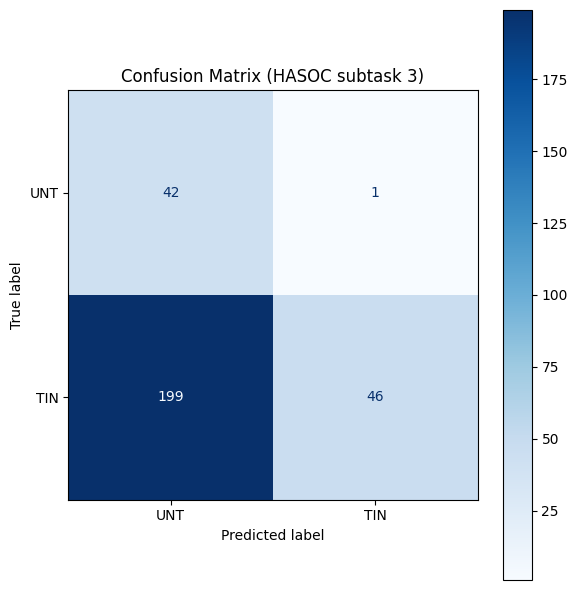

In [43]:
# --- Create test DataLoader or inference loader (unchanged) ---
test_loader = None
inference_only = False

# Defaults in case we never run evaluation
report = "No classification report available."
cm     = []  # empty or [[ ]] 
test_loss = test_acc = test_f1 = test_precision = test_recall = 0.0


if df_test is not None and len(df_test) > 0:
    has_labels = 'label' in df_test.columns
    test_dataset = TextClassificationDataset(
        texts = df_test['clean_text'].tolist(),
        labels= df_test['label'].tolist() if has_labels else None,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )
    if has_labels:
        print(f"✔️ Built evaluation DataLoader for {len(test_dataset)} labeled test samples.")
    else:
        inference_only = True
        print(f"ℹ️ Built inference DataLoader for {len(test_dataset)} test samples (no labels).")
else:
    print("⚠️ No test data found; skipping test loader.")



# --- Run test set evaluation or inference ---
if test_loader is None:
    print("\nSkipping test set evaluation/inference (no test_loader).")

elif not inference_only:
    # ----- EVALUATION WITH LABELS -----
    print("\nEvaluating on Test Set...")
    test_loss, test_acc, test_f1, test_precision, test_recall, test_labels, test_preds = eval_model(
        model, test_loader, device, len(test_dataset), loss_fn
    )

    # Print metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test F1-score:  {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")

    # Build a properly ordered list of (int) labels and their names
    int_labels   = [v for _,v in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    target_names = [k for k,_ in sorted(LABEL_MAP.items(), key=lambda x: x[1])]

    report = classification_report(
        y_true=test_labels,
        y_pred=test_preds,
        labels=int_labels,          # ensure we include every class
        target_names=target_names,
        digits=4,
        zero_division=0
    )

    print("\nClassification Report:")
    print(report)

    # Confusion matrix display & save
    cm = confusion_matrix(test_labels, test_preds, labels=int_labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix ({DATASET_TYPE} subtask {SUBTASK.upper()})')
    fig.tight_layout()
    
    cm_path = os.path.join(OUTPUT_DIR, f'cm_{DATASET_TYPE}_{SUBTASK}.png')
    fig.savefig(cm_path)
    print(f"Saved confusion matrix to {cm_path}")


elif inference_only:
    # ----- INFERENCE-ONLY, NO TRUE LABELS -----
    print("\nRunning inference on unlabeled Test Set...")
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)

    inv_label_map = {v:k for k,v in LABEL_MAP.items()}
    pred_strs = [inv_label_map[p] for p in all_preds]

    out_df = pd.DataFrame({
        'id':        df_test.get('id', range(len(all_preds))),
        'prediction':    all_preds,
        'prediction_str': pred_strs
    })
    out_path = os.path.join(OUTPUT_DIR,
    f'{DATASET_TYPE}_subtask{SUBTASK.upper()}_predictions.csv')

    out_df.to_csv(out_path, index=False)
    print(f"▶️ Inference done. Saved predictions to {out_path}")

    # No true labels → no report or confusion matrix
    report = "Inference-only mode; no classification report."
    cm     = []

    # How many examples to display
    n_display = 20

    # Get unique predicted class labels (e.g. ['NOT','OFF'])
    pred_classes = out_df['prediction_str'].unique().tolist()
    n_classes = len(pred_classes)
    # Compute how many per class (at least one)
    per_class = max(1, n_display // n_classes)

    # Sample per class
    sampled = (
        out_df
        .groupby('prediction_str', group_keys=False)
        .apply(lambda grp: grp.sample(min(len(grp), per_class), random_state=SEED))
    )

    # If we overshot (e.g. 2 classes × 3 = 6 > 5), just pick n_display at random
    if len(sampled) > n_display:
        sampled = sampled.sample(n_display, random_state=SEED)

    # Finally, shuffle the small sample so it’s not grouped by class
    sampled = sampled.sample(frac=1, random_state=SEED).reset_index(drop=True)

    print("\nSample predictions (balanced across predicted classes):")
    print(sampled)


## 10. Save Artifacts and Results

Save the trained model, tokenizer, training history plots, and final results.


Saving artifacts...
Best model and tokenizer saved to: model_output/best_model
Training history plot saved to model_output/training_history.png
Results saved to model_output/results_HASOC_subtask3.json


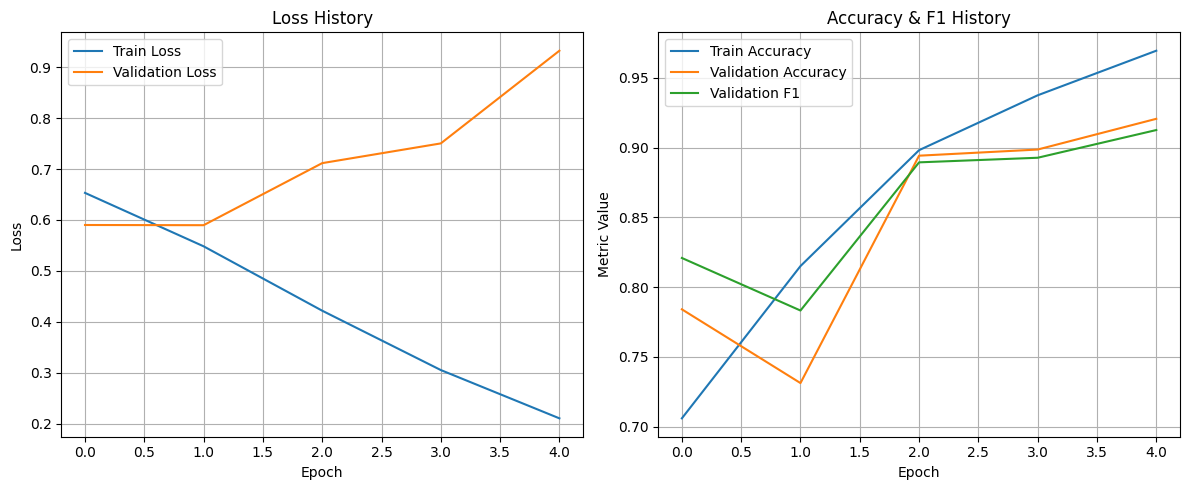

In [44]:
# After saving artifacts

print("\nSaving artifacts...")

# --- Save Model and Tokenizer ---
model_save_path = os.path.join(OUTPUT_DIR, 'best_model')
try:
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Best model and tokenizer saved to: {model_save_path}")
except Exception as e:
    print(f"Error saving model or tokenizer: {e}")

# --- Plot Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.plot(history['val_f1'], label='Validation F1')
plt.title('Accuracy & F1 History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
history_plot_path = os.path.join(OUTPUT_DIR, 'training_history.png')
try:
    plt.savefig(history_plot_path)
    print(f"Training history plot saved to {history_plot_path}")
    # plt.show() # Uncomment to display inline
except Exception as e:
    print(f"Error saving history plot: {e}")

# --- Save Configuration and Results to JSON ---
# Reuse config_dict from earlier
# Ensure confusion_matrix is serializable
cm_data = cm.tolist() if hasattr(cm, 'tolist') else cm

results = {
    'config': config_dict,
    'training_info': {
        'epochs_run': len(history['train_loss']),
        'total_training_time_seconds': total_training_time,
        'best_validation_loss': best_val_loss if best_model_state is not None else None,
        'best_epoch': best_epoch if best_model_state is not None else None
    },
    'history': history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1_score_weighted': test_f1,
        'precision_weighted': test_precision,
        'recall_weighted': test_recall
    },
    'classification_report': report,
    'confusion_matrix': cm_data
}

results_filename = f"results_{DATASET_TYPE}_subtask{SUBTASK.lower()}.json"
results_path     = os.path.join(OUTPUT_DIR, results_filename)

try:
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {results_path}")
except Exception as e:
    print(f"Error saving results JSON: {e}")

## 11. Comparing Classification Reports

⚠️  Could not find model_output/results_OffenseEval_subtaska.json, skipping.
⚠️  Could not find model_output/results_OffenseEval_subtaskb.json, skipping.
⚠️  Could not find model_output/results_OffenseEval_subtaskc.json, skipping.


,dataset,subtask,accuracy,f1_weighted
0,HASOC,1,0.727667,0.745941
1,HASOC,2,0.635417,0.600026
2,HASOC,3,0.305556,0.312188


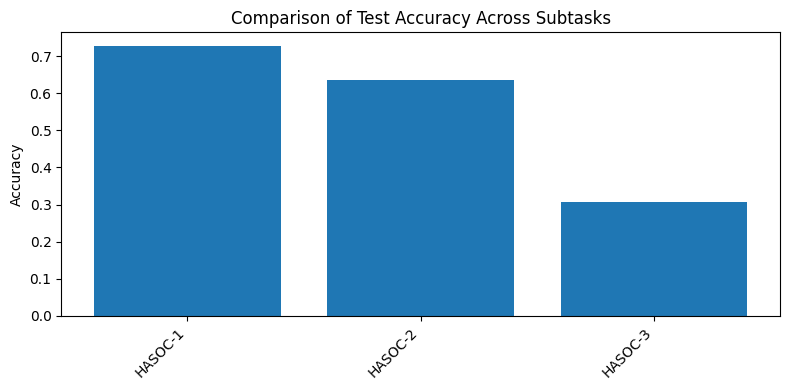

In [48]:

# List the datasets & subtasks you care about
configs = [
    ('HASOC',      '1'),
    ('HASOC',      '2'),
    ('HASOC',      '3'),
    ('OffenseEval','a'),
    ('OffenseEval','b'),
    ('OffenseEval','c'),
]

results = []
for ds, st in configs:
    # load the JSON you saved in each run: results_{DS}_subtask{ST}.json
    fn = f"results_{ds}_subtask{st}.json"
    path = os.path.join(OUTPUT_DIR, fn)
    try:
        with open(path) as f:
            r = json.load(f)
        acc = r['test_metrics']['accuracy']
        f1  = r['test_metrics']['f1_score_weighted']
        results.append({
            'dataset': ds,
            'subtask': st,
            'accuracy': acc,
            'f1_weighted': f1
        })
    except FileNotFoundError:
        print(f"⚠️  Could not find {path}, skipping.")

# Build a DataFrame and display
df = pd.DataFrame(results)
display(df)

plt.figure(figsize=(8,4))
plt.bar(
    [f"{r['dataset']}-{r['subtask']}" for r in results],
    [r['accuracy'] for r in results]
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Comparison of Test Accuracy Across Subtasks")
plt.tight_layout()
plt.show()


## 12. Explainability (Attention Visualization)

 Visualizing attention helps in understanding which parts of the input text the model focuses on when making predictions, thereby offering insights into its decision-making process. We'll use custom plotting functions with matplotlib and seaborn for flexibility and control.

### Step 1: Helper Function to Extract Attentions and Tokens

This utility function handles the preprocessing of text, tokenization, running the model to get attention weights, and preparing tokens for visualization.

In [49]:
# Cell 2: Helper function to get attentions and tokens
def get_bert_attentions_and_tokens(
    model: BertForSequenceClassification, 
    tokenizer: BertTokenizer, 
    text: str, 
    device: torch.device, 
    max_len: int
) -> tuple | None:
    """
    Preprocesses text, gets BERT model attentions, and corresponding tokens.

    Args:
        model: Fine-tuned BERT model (must be loaded with output_attentions=True).
        tokenizer: BERT tokenizer.
        text: Input text string.
        device: PyTorch device (e.g., 'cuda', 'cpu').
        max_len: Maximum sequence length for tokenization.

    Returns:
        A tuple (tokens, attentions_per_layer, processed_text) or None if error.
        - tokens: List of token strings (effective length).
        - attentions_per_layer: List of tensors, one for each layer.
                                Each tensor shape: (num_heads, effective_seq_len, effective_seq_len).
        - processed_text: The text after preprocessing.
    """
    # Ensure model outputs attentions
    if not model.config.output_attentions:
        print("Error: Model was not loaded with output_attentions=True.")
        try:
            model.config.output_attentions = True # Attempt to reconfigure
            print("Attempted to reconfigure model to output attentions. For reliability, consider reloading the model with this flag set.")
        except Exception as e:
            print(f"Could not reconfigure model: {e}. Please reload the model with output_attentions=True.")
            return None
            
    # Assuming preprocess_text is defined in your notebook's scope
    processed_text = preprocess_text(text) 
    inputs = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    ).to(device)

    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    attentions = outputs.attentions  # Tuple of (batch_size, num_heads, seq_len, seq_len) per layer

    # Squeeze batch dimension and move to CPU
    attentions_per_layer_cpu = [layer_attention.squeeze(0).cpu() for layer_attention in attentions]
    
    tokens_all = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).cpu().numpy())

    # Determine effective sequence length (excluding padding)
    effective_len = attention_mask.squeeze(0).sum().item()
    
    # Slice tokens to effective length
    tokens_effective = tokens_all[:effective_len]
    
    # Slice attention matrices to effective length for all layers and heads
    attentions_per_layer_effective = [
        att_layer[:, :effective_len, :effective_len] for att_layer in attentions_per_layer_cpu
    ]

    return tokens_effective, attentions_per_layer_effective, processed_text

### Step 2: Custom Plotting Functions

These functions will generate the actual visualizations (2D heatmaps for token-to-token attention and bar charts for [CLS] token attention).

In [50]:
# Cell 3: Custom Plotting Functions for Attention
def plot_attention_heatmap(
    attention_matrix: np.ndarray, 
    x_labels: list, 
    y_labels: list, 
    title: str = "Attention Heatmap",
    figsize_base: tuple = (0.7, 0.5), # Width, height per token
    min_figsize: tuple = (8, 6), # Minimum figure size
    cmap: str = "viridis",
    annot: bool = False # Set to True to show attention scores on the heatmap (for small matrices)
):
    """Plots a 2D attention matrix as a heatmap using Seaborn."""
    num_x_tokens = len(x_labels)
    num_y_tokens = len(y_labels)
    
    fig_width = max(min_figsize[0], num_x_tokens * figsize_base[0])
    fig_height = max(min_figsize[1], num_y_tokens * figsize_base[1])
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sns.heatmap(attention_matrix, xticklabels=x_labels, yticklabels=y_labels, cmap=cmap, annot=annot, fmt=".2f", ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Attending To (Key)", fontsize=12)
    ax.set_ylabel("Attended From (Query)", fontsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout(pad=0.5)
    return fig


def plot_cls_token_attention_barchart(
    cls_attention_scores: np.ndarray, 
    tokens: list, # Full list of tokens including [CLS]
    tokenizer: BertTokenizer, # Pass tokenizer to identify CLS token
    title: str = "[CLS] Token Attention to Other Tokens",
    figsize_base_width_per_token: float = 0.6,
    min_fig_width: float = 8,
    fig_height: float = 4
):
    """Plots attention scores from [CLS] token to other tokens as a bar chart."""
    cls_token_str = tokenizer.cls_token
    
    # Exclude [CLS] token itself from the bar chart's x-axis
    plot_tokens = tokens[1:] if tokens and tokens[0] == cls_token_str else tokens
    plot_scores = cls_attention_scores[1:] if tokens and tokens[0] == cls_token_str else cls_attention_scores
    
    if not plot_tokens: 
        print(f"Warning: No tokens to plot for '{title}'. Sequence might be too short or only contain [CLS].")
        return None

    fig_width = max(min_fig_width, len(plot_tokens) * figsize_base_width_per_token)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    ax.bar(plot_tokens, plot_scores, color='skyblue')
    ax.set_xticks(np.arange(len(plot_tokens))) # Ensure all labels are shown
    ax.set_xticklabels(plot_tokens, rotation=75, ha="right", fontsize=10)
    ax.set_ylabel("Average Attention Score from [CLS]")
    ax.set_title(title, fontsize=14)
    plt.tight_layout(pad=0.5)
    return fig

### Step 3: Main Visualization Workflow Function

This improved function orchestrates the process of getting attentions and calling the plotting functions. It allows selecting layers and heads.

In [51]:
# Cell 4: Main Visualization Workflow Function
def improved_visualize_attention(
    model: BertForSequenceClassification, 
    tokenizer: BertTokenizer, 
    text: str, 
    device: torch.device, 
    max_len: int,
    layer_to_viz: int = -1,          # Default to last layer (-1 means last, -2 second last etc.)
    head_to_viz: str | int = 'average', # Options: 'average', 'all', or a specific head index (0 to num_heads-1)
    output_dir: str = "model_output", # Directory to save plots
    sample_id: str = "sample",       # Identifier for filenames (e.g., DataFrame index or sample number)
    show_plots: bool = True,         # Whether to display plots inline
    save_plots: bool = True          # Whether to save plots to output_dir
):
    """
    Generates and optionally saves/shows attention visualizations for a given text, layer, and head.
    Produces:
    1. Bar chart of [CLS] token's average attention (across heads) to other tokens for the specified layer.
    2. 2D heatmap(s) of token-to-token attention for the specified layer and head(s).
    """
    os.makedirs(output_dir, exist_ok=True) # Ensure output directory exists

    attention_data = get_bert_attentions_and_tokens(model, tokenizer, text, device, max_len)
    if attention_data is None:
        print(f"Could not retrieve attention data for sample {sample_id}.")
        return

    tokens, attentions_per_layer, processed_text = attention_data
    
    if not tokens:
        print(f"No tokens returned for sample {sample_id}, cannot visualize.")
        return

    num_layers = len(attentions_per_layer)
    num_heads = attentions_per_layer[0].shape[0] # (num_heads, seq_len, seq_len)

    # Validate and adjust layer_to_viz
    actual_layer_idx = layer_to_viz
    if actual_layer_idx < 0:
        actual_layer_idx = num_layers + actual_layer_idx 
    
    if not (0 <= actual_layer_idx < num_layers):
        print(f"Error: layer_to_viz ({layer_to_viz}, resolved to {actual_layer_idx}) is out of range (0-{num_layers-1}). Defaulting to last layer.")
        actual_layer_idx = num_layers - 1
        
    selected_layer_attentions = attentions_per_layer[actual_layer_idx] # Shape: (num_heads, effective_seq_len, effective_seq_len)

    # --- Plot 1: [CLS] Token Average Attention Bar Chart ---
    # Average attention across all heads for the selected layer
    avg_attention_all_heads_selected_layer = torch.mean(selected_layer_attentions, dim=0).numpy() 
    
    # Find [CLS] token index, default to 0 if not found (should always be there with add_special_tokens=True)
    try:
        cls_idx = tokens.index(tokenizer.cls_token)
    except ValueError:
        print(f"Warning: {tokenizer.cls_token} token not found in tokens list. Assuming index 0 for [CLS] attention.")
        cls_idx = 0
            
    cls_to_others_attention = avg_attention_all_heads_selected_layer[cls_idx, :]
    
    # Optional: Normalize [CLS] attention scores (excluding [CLS] itself)
    # score_sum = np.sum(cls_to_others_attention[cls_idx+1:])
    # if score_sum > 0:
    #    cls_to_others_attention[cls_idx+1:] = cls_to_others_attention[cls_idx+1:] / score_sum

    bar_title = f"[CLS] Avg. Head Attn. (L{actual_layer_idx}) - Sample {sample_id}\nText: \"{text[:40]}...\""
    fig_bar = plot_cls_token_attention_barchart(
        cls_attention_scores=cls_to_others_attention,
        tokens=tokens,
        tokenizer=tokenizer,
        title=bar_title
    )
    if fig_bar:
        if save_plots:
            bar_chart_path = os.path.join(output_dir, f"attn_bar_{sample_id}_L{actual_layer_idx}.png")
            try:
                fig_bar.savefig(bar_chart_path, bbox_inches='tight')
                print(f"Bar chart saved: {bar_chart_path}")
            except Exception as e:
                print(f"Error saving bar chart for sample {sample_id}: {e}")
        if show_plots:
            plt.show()
        plt.close(fig_bar)

    # --- Plot 2: Full Token-to-Token Attention Heatmap(s) ---
    plot_head_indices = []
    if head_to_viz == 'average':
        plot_head_indices.append('average')
    elif head_to_viz == 'all':
        plot_head_indices.extend(range(num_heads))
    elif isinstance(head_to_viz, int) and 0 <= head_to_viz < num_heads:
        plot_head_indices.append(head_to_viz)
    else:
        print(f"Notice: Invalid head_to_viz value: {head_to_viz}. Defaulting to 'average' for heatmap.")
        plot_head_indices.append('average')

    for head_spec in plot_head_indices:
        if head_spec == 'average':
            attention_matrix_for_plot = torch.mean(selected_layer_attentions, dim=0).numpy()
            head_label = "AvgHead"
        else: # Specific head index
            attention_matrix_for_plot = selected_layer_attentions[head_spec, :, :].numpy()
            head_label = f"Head{head_spec}"

        heatmap_title = f"Token-to-Token Attn. (L{actual_layer_idx}, {head_label}) - Sample {sample_id}\nText: \"{text[:40]}...\""
        fig_heatmap = plot_attention_heatmap(
            attention_matrix=attention_matrix_for_plot,
            x_labels=tokens,
            y_labels=tokens,
            title=heatmap_title
        )
        if fig_heatmap:
            if save_plots:
                heatmap_filename = f"attn_heatmap_{sample_id}_L{actual_layer_idx}_{head_label}.png"
                heatmap_path = os.path.join(output_dir, heatmap_filename)
                try:
                    fig_heatmap.savefig(heatmap_path, bbox_inches='tight')
                    print(f"Heatmap saved: {heatmap_path}")
                except Exception as e:
                    print(f"Error saving heatmap for L{actual_layer_idx}, {head_label} (Sample {sample_id}): {e}")
            if show_plots:
                plt.show()
            plt.close(fig_heatmap)
            
    print(f"Finished visualization for sample {sample_id}.")


### Step 4: Run Visualization Workflow
This cell reloads the best-performing model model with `output_attentions=True` and then iterates through a few samples from the test set to generate and display/save the visualizations.


Reloading model from model_output/best_model for attention visualization...
Model reloaded successfully for visualization.

--- Visualizing Sample 1 (DataFrame Index: 45) ---
Text: dr. qanta ahmed: rep. omar is a disgrace to islam HTTPURL via @USER...
True Label: HOF (1)
Predicted Label: HOF (1)
Bar chart saved: model_output/attn_bar_df_idx_45_L11.png


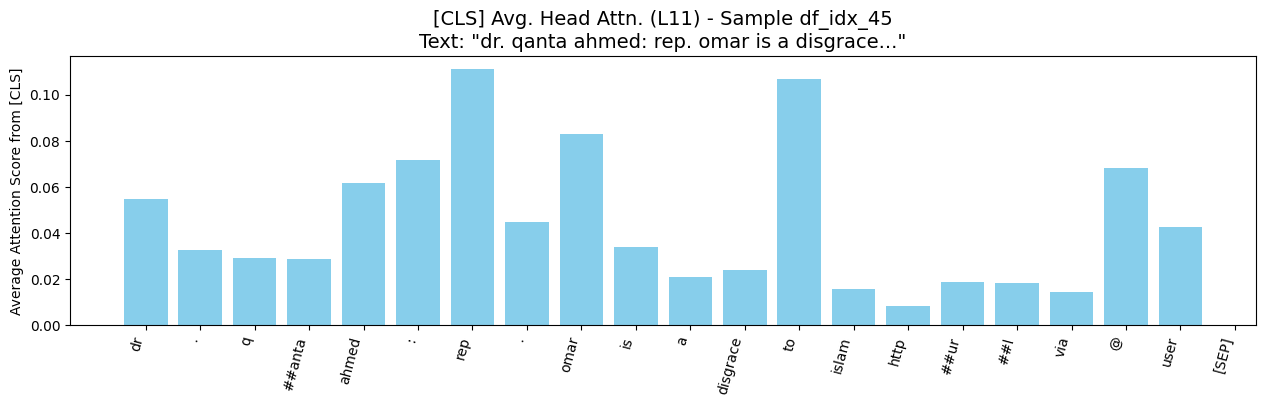

Heatmap saved: model_output/attn_heatmap_df_idx_45_L11_AvgHead.png


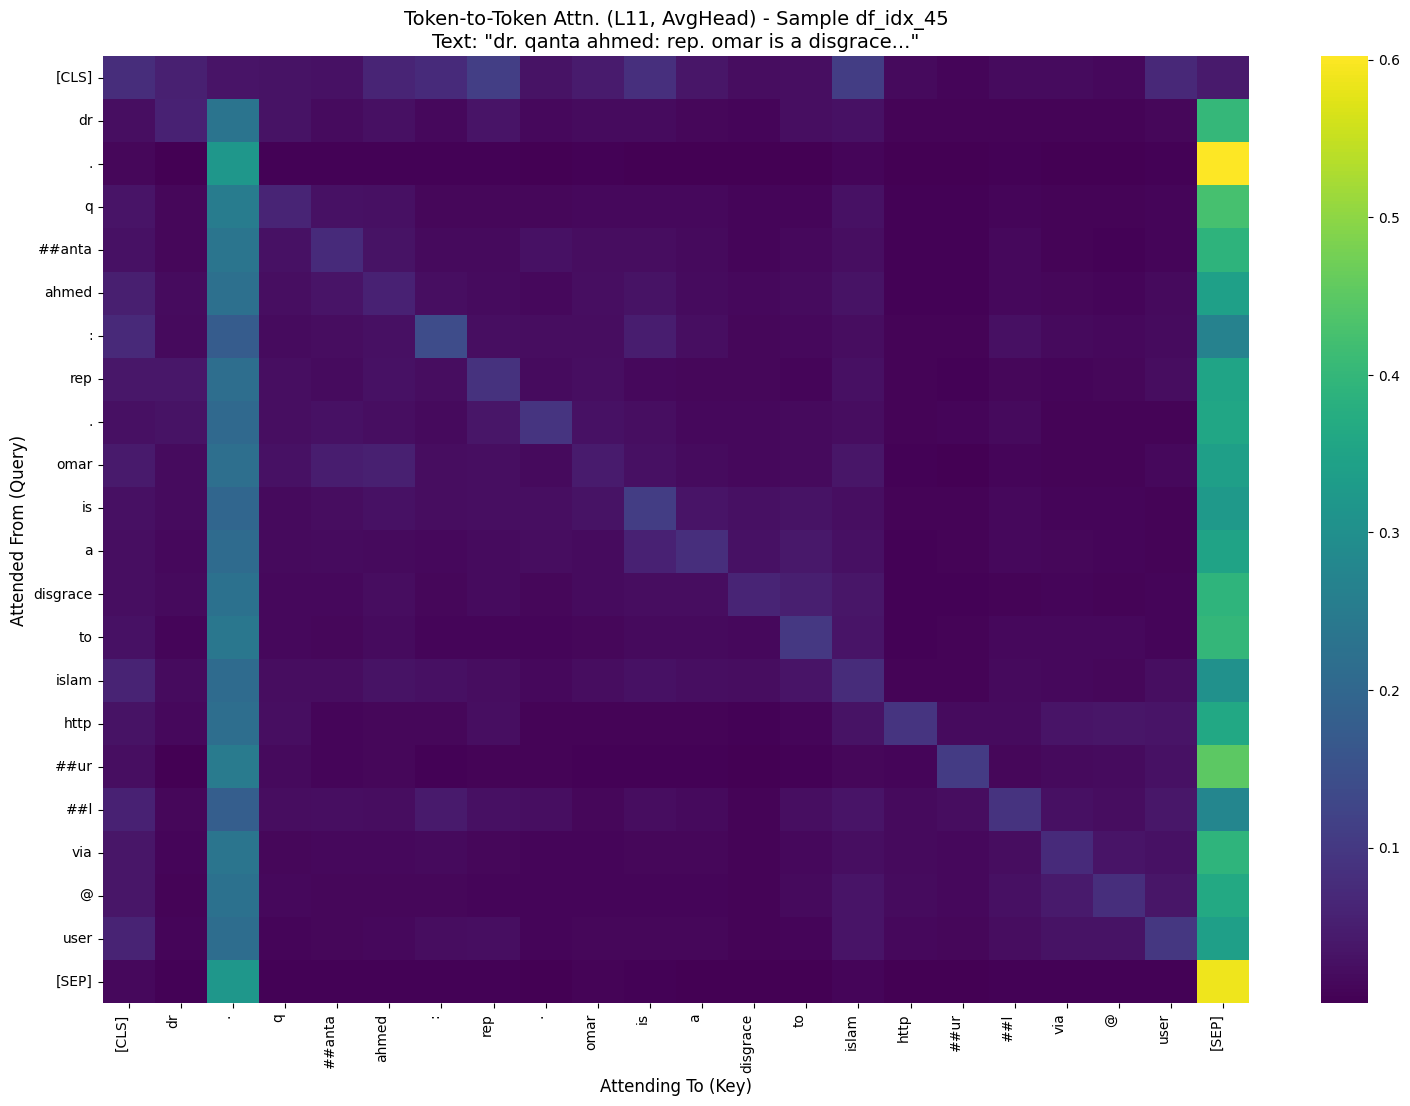

Finished visualization for sample df_idx_45.

--- Visualizing Sample 2 (DataFrame Index: 157) ---
Text: good. btw the majority of northern irish voted to remain in the eu. why should they follow an english prime minister who has no democratic legitimacy to continue pursuing the failed #brexit project? #...
True Label: HOF (1)
Predicted Label: NOT (0)
Bar chart saved: model_output/attn_bar_df_idx_157_L11.png


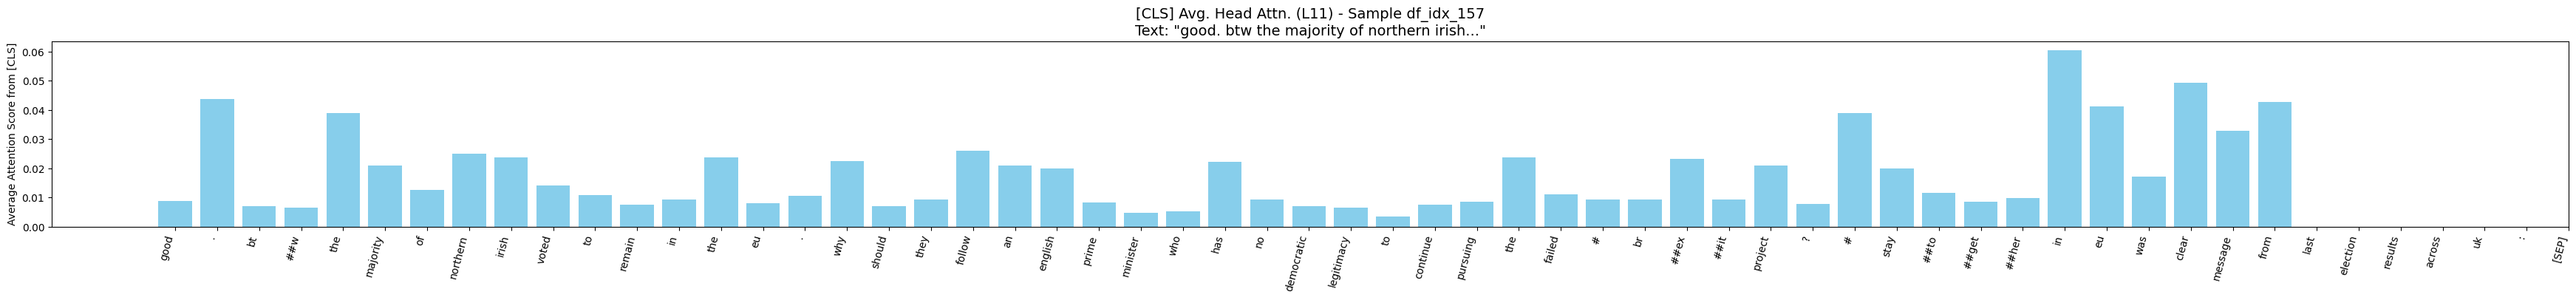

Heatmap saved: model_output/attn_heatmap_df_idx_157_L11_AvgHead.png


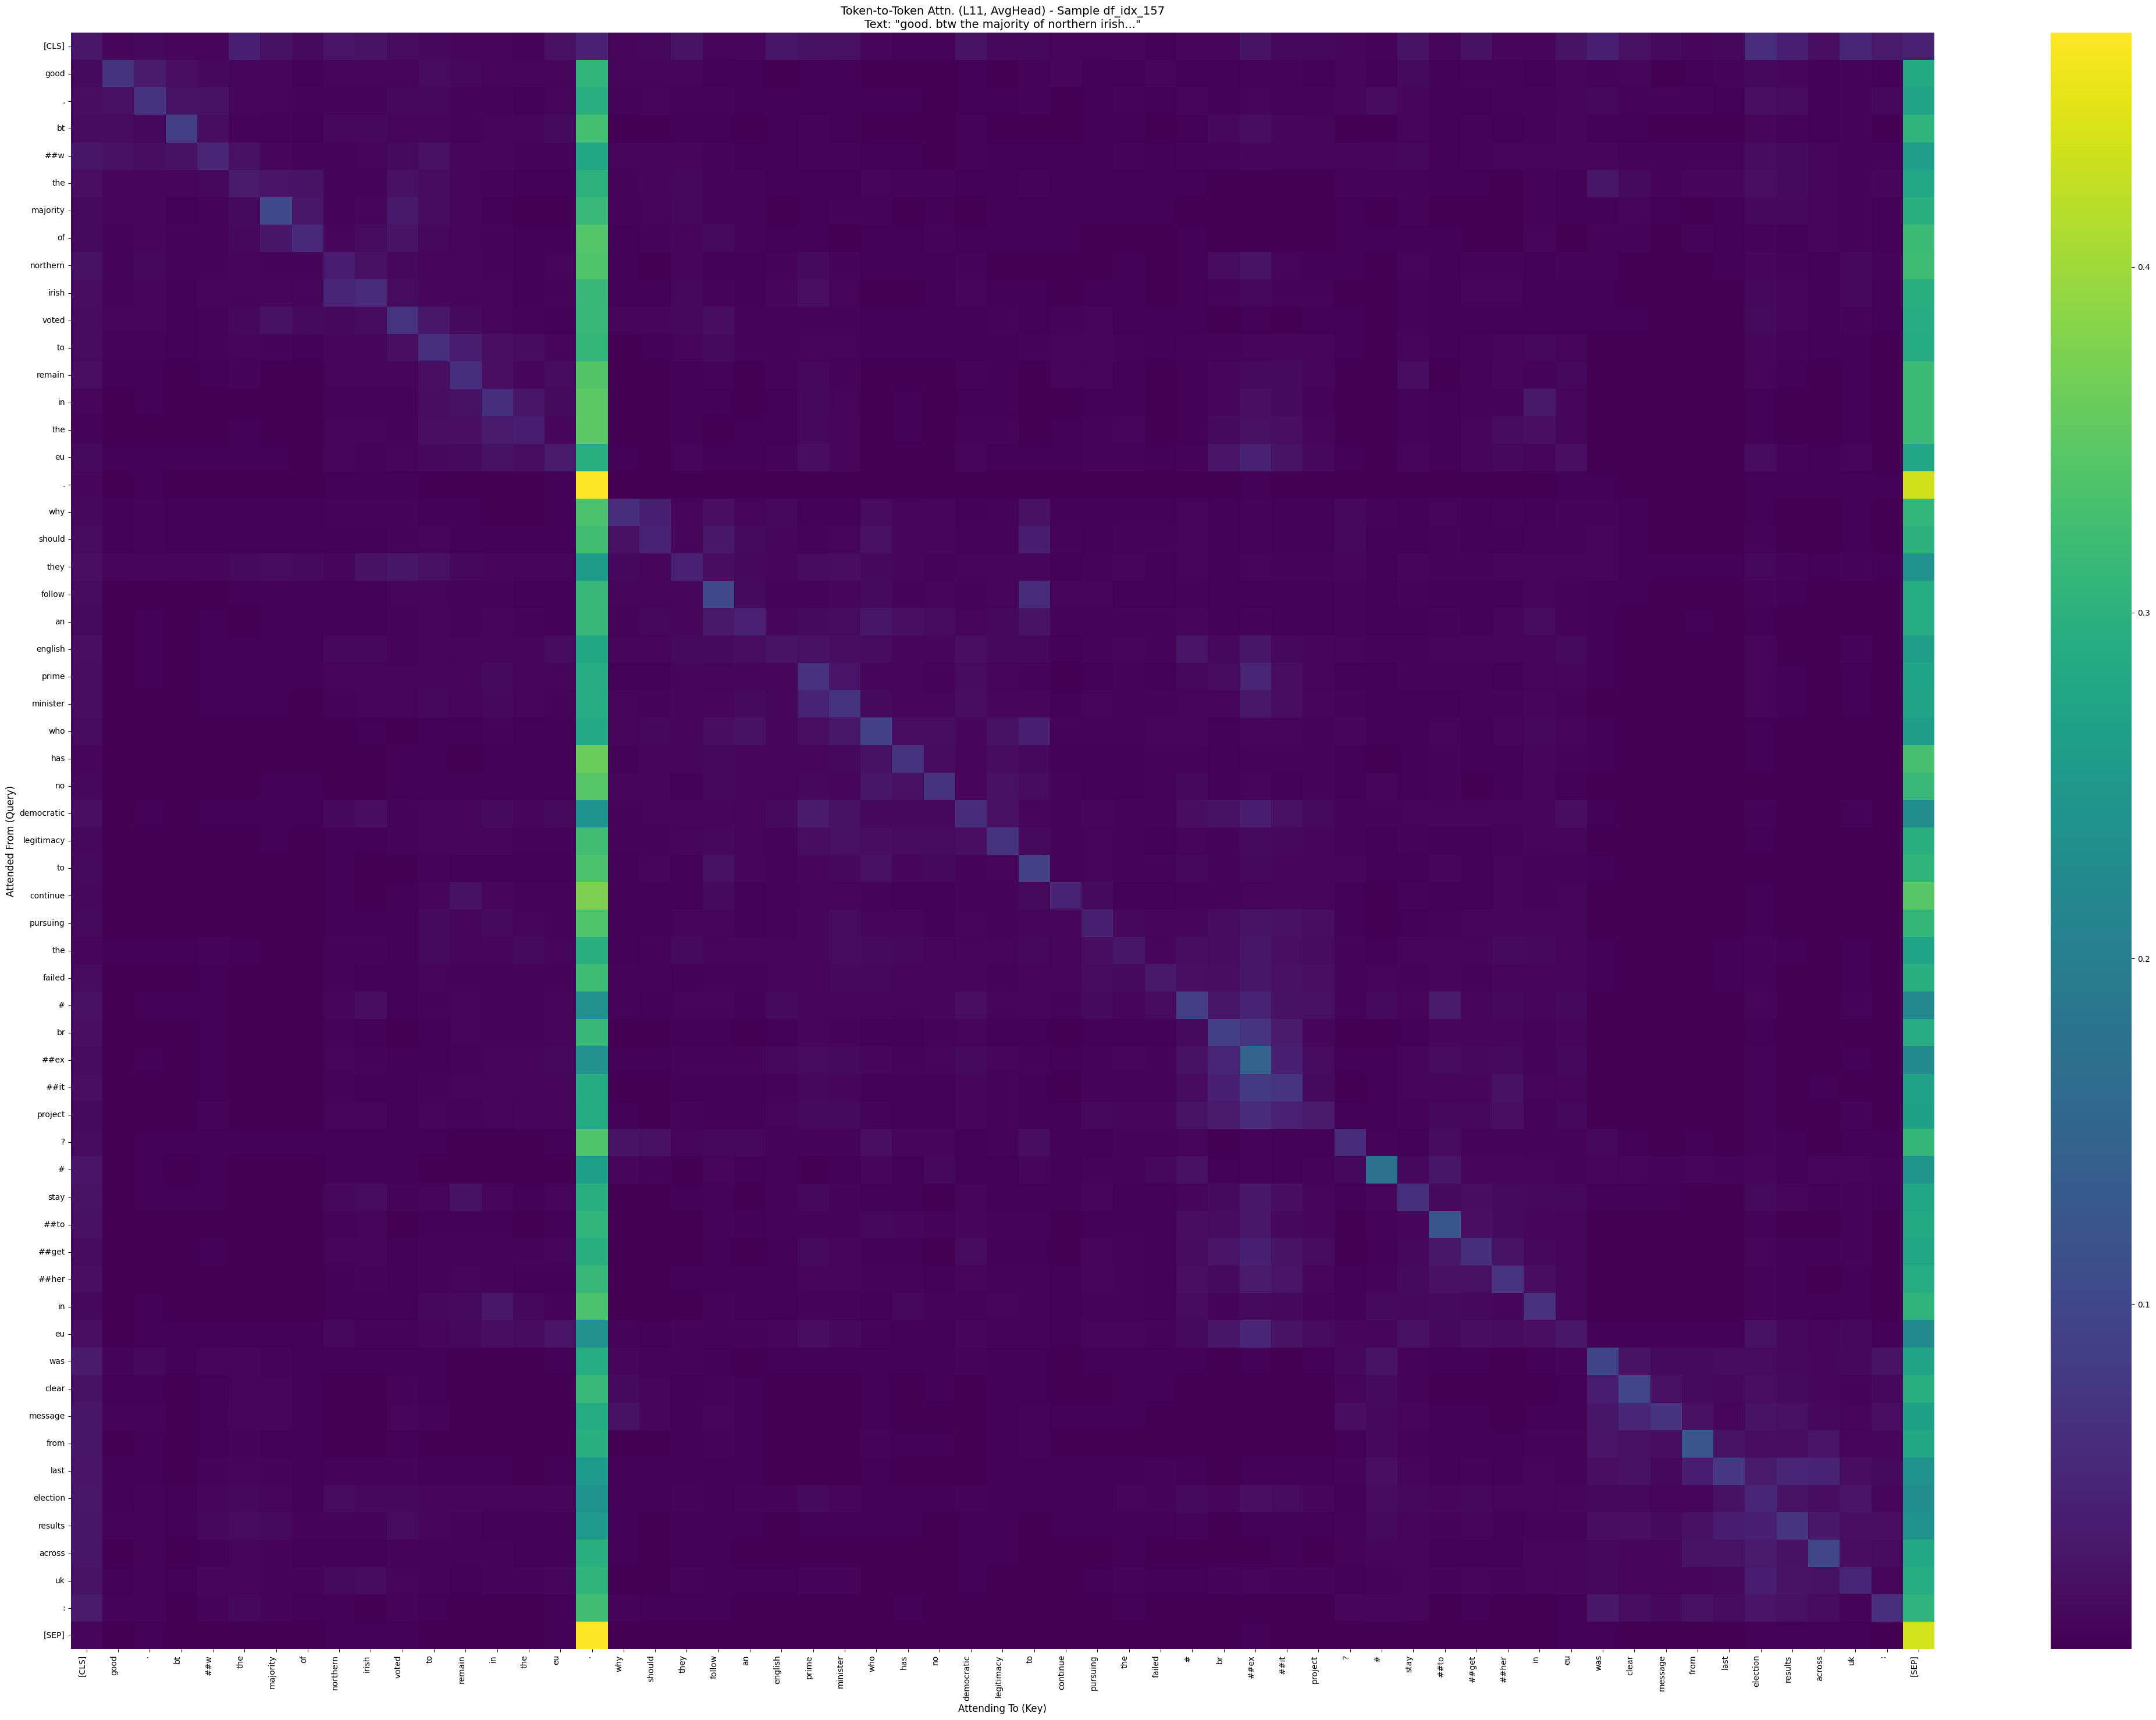

Finished visualization for sample df_idx_157.

--- Visualizing Sample 3 (DataFrame Index: 256) ---
Text: people like pandit amit are making me go farther away from #hinduism and closer to atheism. btw i have already distanced myself from the #bjp that i once supported because of such chutiyes. #istandwit...
True Label: HOF (1)
Predicted Label: NOT (0)
Bar chart saved: model_output/attn_bar_df_idx_256_L11.png


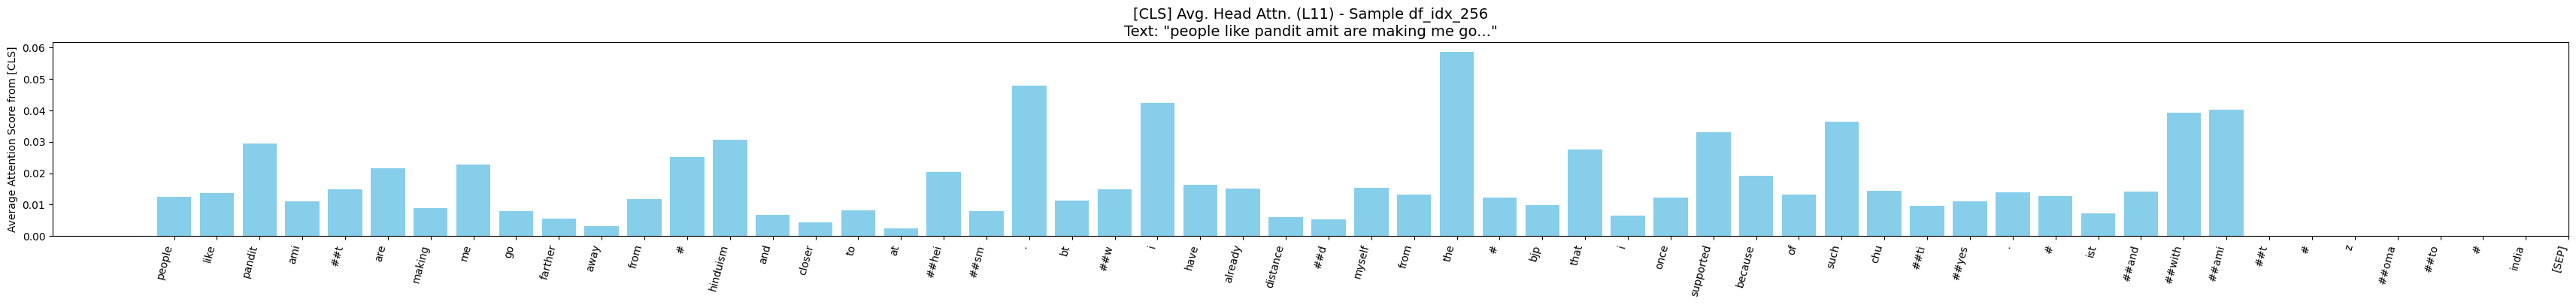

Heatmap saved: model_output/attn_heatmap_df_idx_256_L11_AvgHead.png


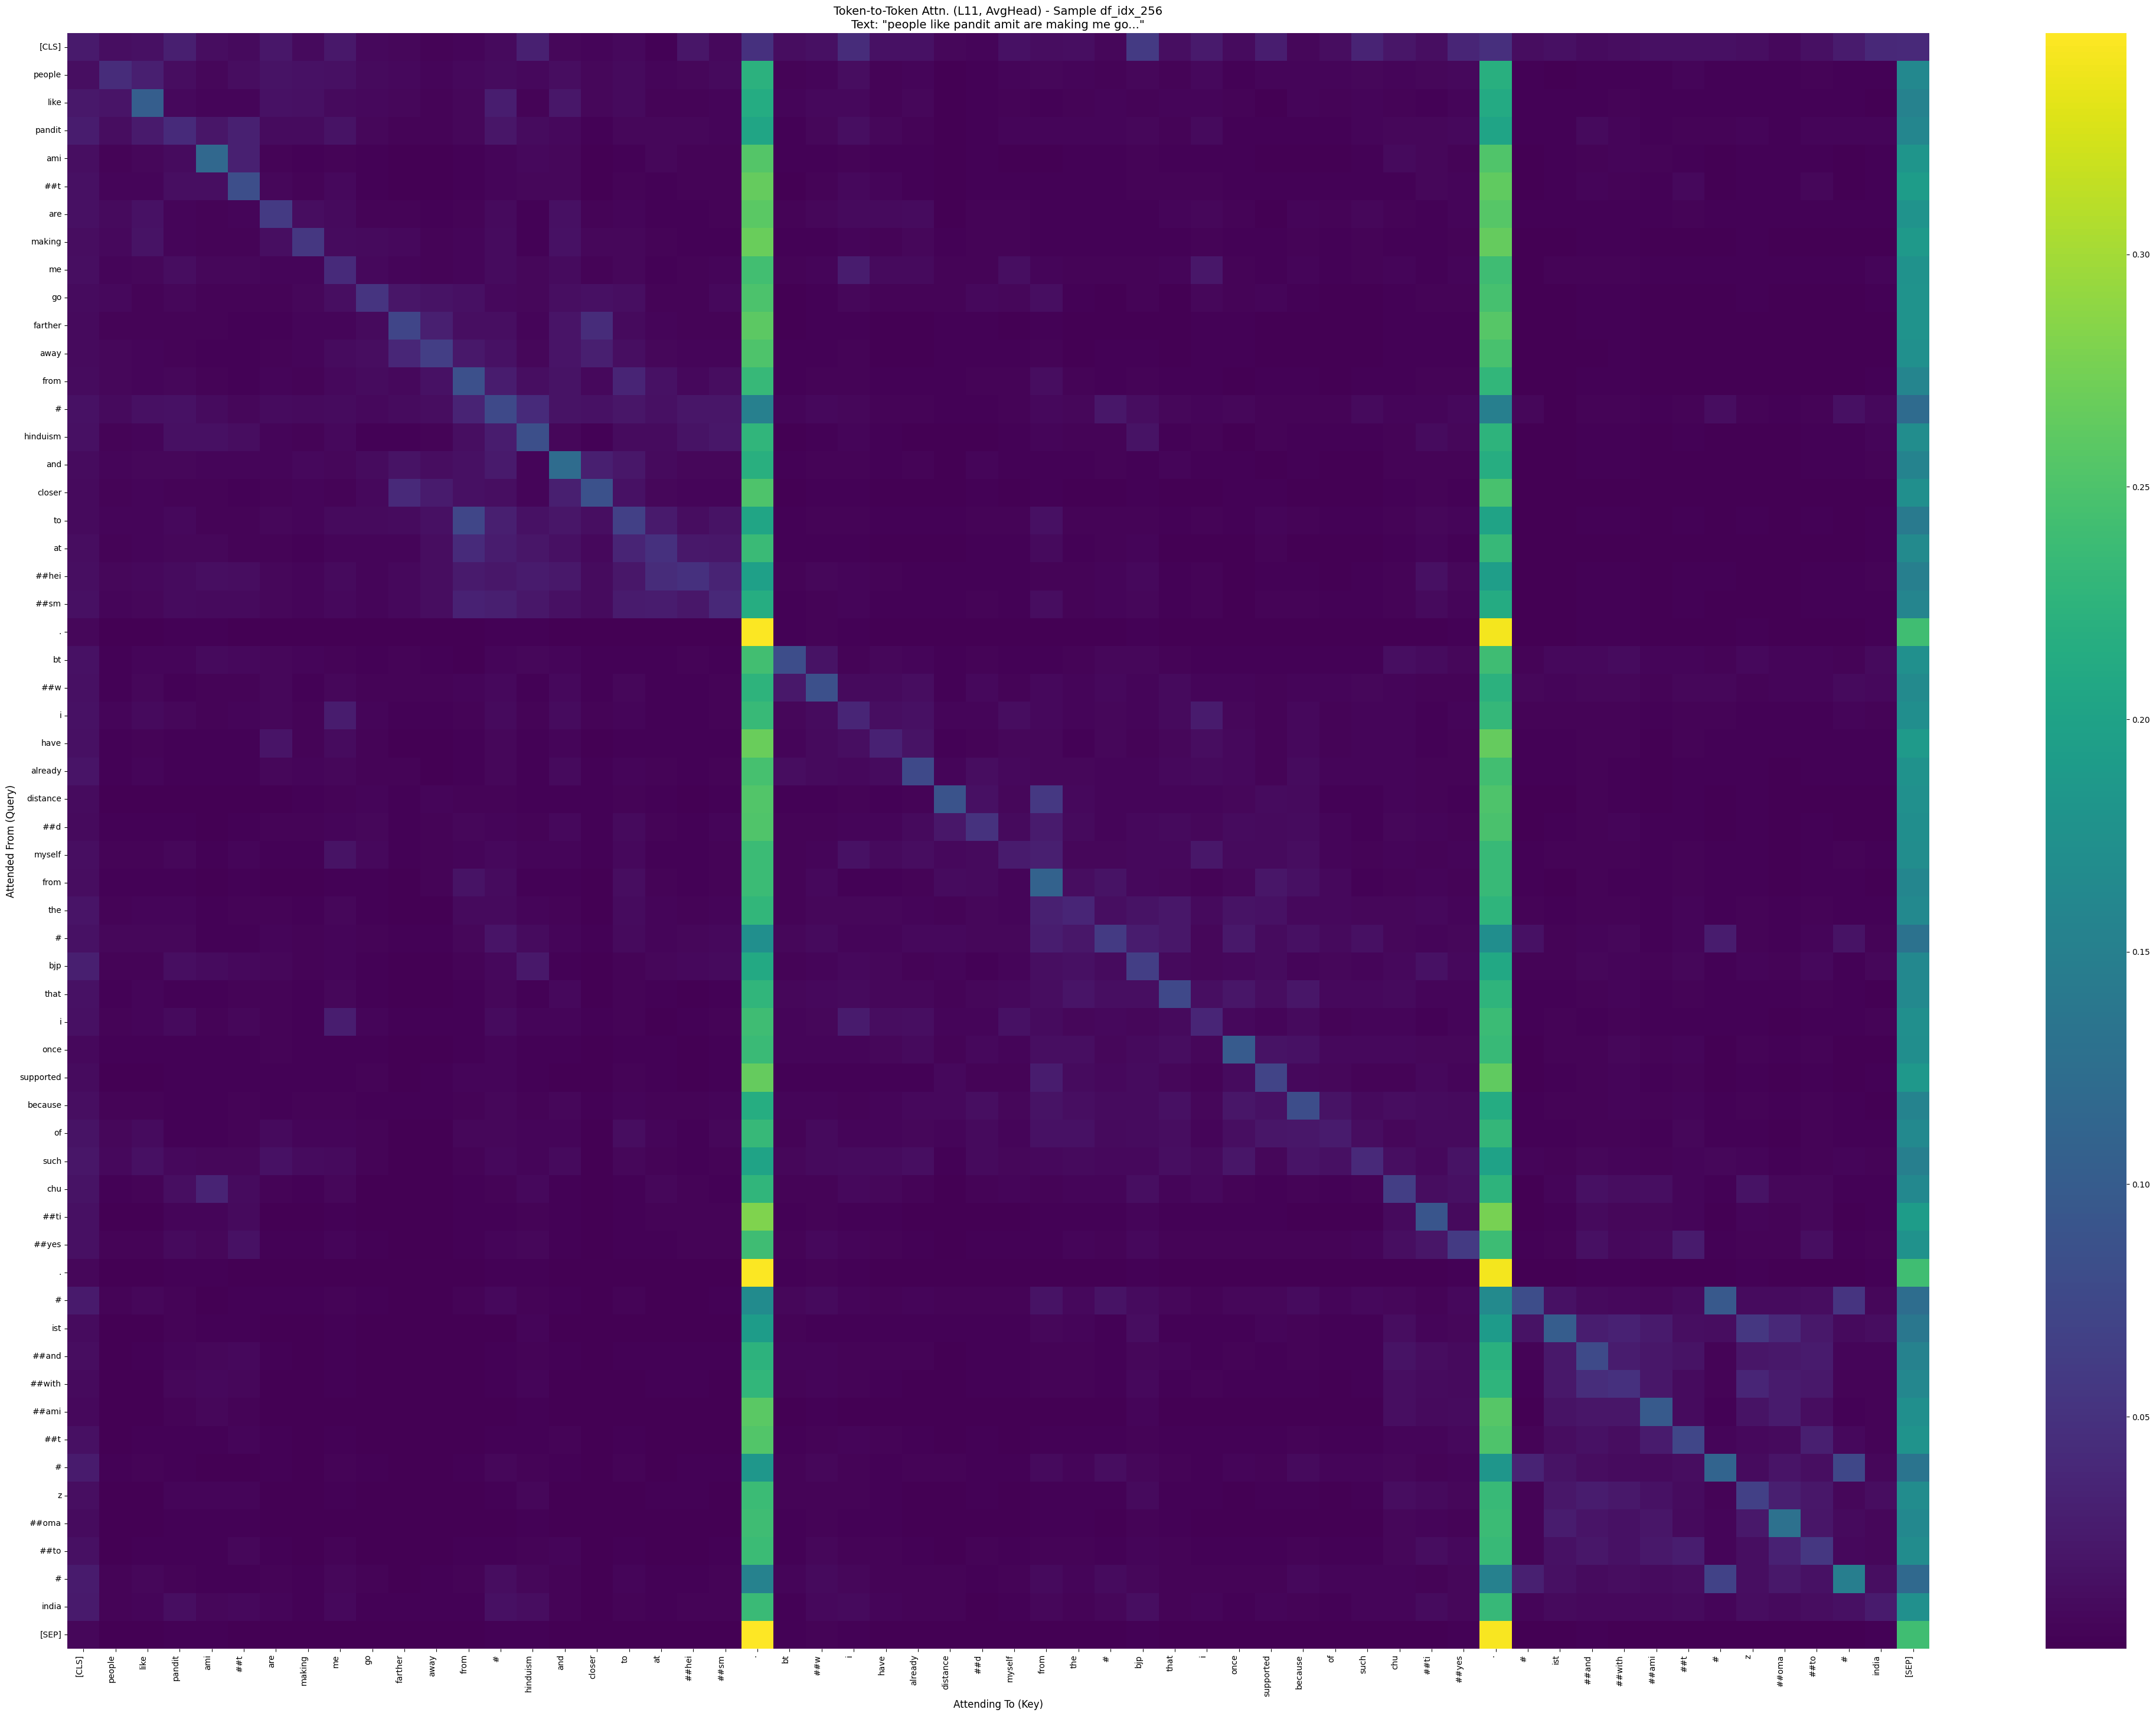

Finished visualization for sample df_idx_256.


In [54]:
# Cell 5: Reload Model and Run Visualization Workflow

# --- Ensure these variables are defined from your notebook's context ---
# model: your trained model object (before saving, or load it if this is a new session)
# tokenizer: your loaded tokenizer
# device: your torch device
# MAX_LEN: max sequence length
# OUTPUT_DIR: directory for saving plots
# df_test: your preprocessed test dataframe (must contain 'clean_text' and optionally 'label')
# LABEL_MAP: your label mapping dictionary
# SEED: your random seed for sampling
# preprocess_text: your text preprocessing function

# --- Path to your saved best model ---
# This should be where you saved your model after training, e.g., in Cell 61 of your notebook.
model_save_path = os.path.join(OUTPUT_DIR, 'best_model') 

model_for_viz = None # Initialize
if os.path.exists(model_save_path):
    print(f"\nReloading model from {model_save_path} for attention visualization...")
    try:
        model_for_viz = BertForSequenceClassification.from_pretrained(
            model_save_path, 
            output_attentions=True # CRITICAL: Ensure attentions are output
        )
        model_for_viz.to(device)
        model_for_viz.eval() # Set to evaluation mode
        print("Model reloaded successfully for visualization.")
    except Exception as e:
        print(f"Error reloading model for visualization: {e}")
        print("Please ensure the model was saved correctly and the path is accurate.")
else:
    print(f"Error: Saved model not found at {model_save_path}. Cannot perform attention visualization.")

# --- Visualize for a few samples if model loaded and test data available ---
if model_for_viz and 'df_test' in locals() and df_test is not None and not df_test.empty:
    # Get label names from LABEL_MAP for printing (ensure LABEL_MAP is defined)
    try:
        target_names = [k for k, v in sorted(LABEL_MAP.items(), key=lambda item: item[1])]
    except NameError:
        print("Warning: LABEL_MAP not found. True/Predicted labels won't be human-readable.")
        target_names = None

    num_samples_to_viz = 3 # Visualize for 3 samples
    if len(df_test) < num_samples_to_viz:
        print(f"Warning: Test set has fewer than {num_samples_to_viz} samples. Visualizing all available.")
        num_samples_to_viz = len(df_test)

    if num_samples_to_viz > 0:
        # Ensure SEED is defined for reproducible sampling
        try: _ = SEED 
        except NameError: SEED = 42 
        
        sample_indices = df_test.sample(n=num_samples_to_viz, random_state=SEED).index

        for i, data_idx in enumerate(sample_indices):
            original_text = df_test.loc[data_idx, 'clean_text'] # Use your preprocessed text column

            # --- Get True Label (if available) ---
            true_label_str = "N/A"
            if 'label' in df_test.columns and target_names:
                true_label_int = df_test.loc[data_idx, 'label']
                try:
                    true_label_str = f"{target_names[true_label_int]} ({true_label_int})"
                except IndexError:
                    true_label_str = f"Unknown ({true_label_int})"
            
            # --- Get Predicted Label ---
            pred_inputs = tokenizer.encode_plus(original_text, return_tensors='pt', max_length=MAX_LEN, padding='max_length', truncation=True).to(device)
            with torch.no_grad():
                pred_outputs = model_for_viz(input_ids=pred_inputs['input_ids'], attention_mask=pred_inputs['attention_mask'])
            pred_label_int = torch.argmax(pred_outputs.logits, dim=1).item()
            pred_label_str = "N/A"
            if target_names:
                try:
                    pred_label_str = f"{target_names[pred_label_int]} ({pred_label_int})"
                except IndexError:
                    pred_label_str = f"Unknown ({pred_label_int})"

            print(f"\n--- Visualizing Sample {i+1} (DataFrame Index: {data_idx}) ---")
            print(f"Text: {original_text[:200]}...") # Print a snippet
            print(f"True Label: {true_label_str}")
            print(f"Predicted Label: {pred_label_str}")

            improved_visualize_attention(
                model=model_for_viz,
                tokenizer=tokenizer,
                text=original_text,
                device=device,
                max_len=MAX_LEN, # Ensure MAX_LEN is defined
                layer_to_viz=-1,       # Last layer
                head_to_viz='average', # Average across heads for the 2D heatmap
                                       # Try also: head_to_viz=0 (for head 0) or head_to_viz='all' (for all heads)
                output_dir=OUTPUT_DIR, # Ensure OUTPUT_DIR is defined
                sample_id=f"df_idx_{data_idx}",
                show_plots=True,
                save_plots=True
            )
    else:
        print("No samples in df_test to visualize.")
elif not model_for_viz:
    print("Skipping attention visualization as model_for_viz could not be loaded.")
else:
    print("Skipping attention visualization as test data (df_test) is not available or is empty.")

## 12. Conclusion and Next Steps

This notebook demonstrated the process of fine-tuning BERT for hate speech detection, optionally using FGM for adversarial robustness, evaluating performance, and gaining basic insights via attention visualization.

**Potential Next Steps:**

*   **Hyperparameter Tuning:** Systematically tune `LEARNING_RATE`, `BATCH_SIZE`, `MAX_LEN`, `ADVERSARIAL_EPS`, `PATIENCE` using tools like Optuna or Weights & Biases Sweeps.
*   **Dataset Adaptability:** Refine the `load_and_preprocess_data` function to more robustly handle different dataset formats (especially OffenseEval parts) or create dataset-specific loading functions.
*   **Advanced Adversarial Training:** Implement PGD (Projected Gradient Descent) or explore libraries like TextAttack for more sophisticated attacks and defenses.
*   **Enhanced Explainability:** Integrate libraries like Captum to use methods like Integrated Gradients, SHAP, or LIME for more detailed feature importance analysis.
*   **Error Analysis:** Analyze misclassified examples from the test set to understand model weaknesses and potential biases.
*   **Model Exploration:** Experiment with other transformer architectures like RoBERTa, DeBERTa, etc.
*   **Data Augmentation:** Incorporate techniques like back-translation or synonym replacement (e.g., using `nlpaug`) during training.
*   **Weights & Biases Integration:** Uncomment and configure the (currently missing) wandb integration code for comprehensive experiment tracking.
*   **Deployment:** Explore ways to deploy the trained model for real-time inference using libraries like FastAPI or Flask.